# EDA and cleaning

- Where are the nulls? Naively drop them.
- What is the trend of the stock?

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [60]:
apple = pd.read_csv("../data/sandp500/individual_stocks_15yr_TECHNICALS/AAPL_data.csv")

In [61]:
apple["Date"] = pd.to_datetime(apple["Date"])
apple =  apple.set_index("Date")
#apple = apple.drop("Unnamed: 0", axis = 1)
#apple = apple.drop("Unnamed: 0.1", 1)

In [62]:
apple_targets = pd.read_csv("../data/sandp500/individual_stocks_15yr/AAPL_data.csv")
apple_targets = apple_targets.set_index('Date')
y = apple_targets['Close']

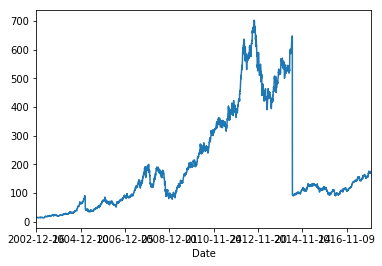

In [63]:
y.plot()

Shift technicals down one so "tomorrow"s close can be predicted with yesterday's TIs

In [64]:
apple.iloc[:, 13:] = apple.iloc[:, 13:].shift()
apple.shape

(3526, 96)

In [65]:
# Drop column of all zeroes
apple = apple.dropna(how = 'all', axis = 1)
apple.shape

(3526, 96)

In [66]:
apple = apple.drop("Acc/Dist_ROC_1" , axis = 1)
apple = apple.drop("Acc/Dist_ROC_5" , axis = 1)
apple = apple.drop("Acc/Dist_ROC_21" , axis = 1)
apple = apple.drop("Acc/Dist_ROC_63" , axis = 1)
apple = apple.drop("Acc/Dist_ROC_125" , axis = 1)
apple = apple.drop("Acc/Dist_ROC_250" , axis = 1)
apple.shape

ValueError: labels ['Acc/Dist_ROC_1'] not contained in axis

In [160]:
apple = apple.tail(3526)
apple.shape

(3526, 116)

In [161]:
apple = apple.dropna(how = 'any', axis = 1)
apple.shape

(3526, 101)

In [162]:
y = apple["Close"]
X = apple.iloc[:, 13:]

# PCA on TIs

- How many dominant PCs are there?
    - Seems like between 5 and 10

(0, 20)

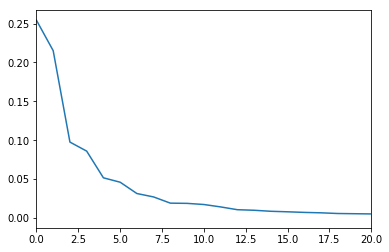

In [165]:
X_standardized = StandardScaler().fit_transform(X)

pca = PCA()
pca.fit(X_standardized)
plt.plot(pca.explained_variance_ratio_)
plt.xlim(0, 20)

Let's take a look at what the first few PCs are composed of. Yellow cells indicate contribution by feature

It would help a lot if I knew what the hell these TIs were

In [166]:
pc_composition = pd.DataFrame(pca.components_[0:8], index = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"], columns = X.columns).T


In [167]:
def highlight_bottom(s):
    '''
    highlight the max and min 3 in a Series yellow.
    '''
    is_blue = s.isin(s.sort_values()[:5])
    return ['background-color: aqua' if v else '' for v in is_blue]


def highlight_top(s):
    '''
    highlight the max and min 3 in a Series yellow.
    '''
    is_red = s.isin(s.sort_values(ascending = False)[:5])
    return ['background-color: crimson' if v else '' for v in is_red]

pc_composition.style.apply(highlight_bottom).apply(highlight_top)

# Baseline predictions

- How well can we predict today's closing price with yesterday's technicals? Which features are influential?

In [169]:
# calculate train split size
2 * X.shape[0]  / 3

2350.6666666666665

In [170]:
#chronological train test split

X_train, X_test = apple.iloc[:2350, 13:], apple.iloc[2350:, 13:]
y_train, y_test = apple.ix[:2350, "Close"], apple.ix[2350:, "Close"]



## Predicting tomorrow with yesterday's value

Before fitting anything let's see what $R^2$ you get by predicting tomorrow with yesterday's value

In [171]:
y_hat_shift = y_test.shift()[1:] 
y_test_shift = y_test[1:]

r2_score(y_hat_shift, y_test_shift)

0.99037735787483827

This is pretty telling. It is not difficult to predict tomorrow's closing price. What you need is to be able to predict far into the future, or this trading signal.

## Random Forest

In [172]:
rf = RandomForestRegressor(n_estimators = 10)
rf.fit(X_train, y_train)
print("Train score:", rf.score(X_train, y_train))
print("Test score:", rf.score(X_test, y_test))

Train score: 0.999798020167
Test score: 0.979657705401


Completely untuned model gets nearly 100% performance on the training set and 98% on the test set.

In [173]:
#technicals associated with closing price
apple.corr()["Close"].abs().sort_values(ascending = False)[4:].head(10)

EMA_1    0.998137
MA_1     0.998137
R1       0.998103
PP       0.998099
S1       0.998068
R2       0.997978
S2       0.997895
R3       0.997829
S3       0.997691
EMA_5    0.996661
Name: Close, dtype: float64

In [174]:
#feature importances
sorted(zip(X.columns, rf.feature_importances_), key = lambda x: abs(x[1]), reverse = True)[:10]

[('PP', 0.17854601447419227),
 ('EMA_5', 0.1539409092554499),
 ('MA_125', 0.15322854424092669),
 ('S1', 0.12130730360357049),
 ('MA_1', 0.11799694923609763),
 ('R1', 0.093063652365413738),
 ('EMA_250', 0.077015579071583601),
 ('EMA_1', 0.035557755546203947),
 ('S3', 0.030224008785960842),
 ('S2', 0.016013960468451289)]

Feature importances seem to agree with correlations between Close price and TIs

# Trying out a modeling Pipeline with PCA

In [175]:
rf_pipe_params = {"pca__n_components": np.arange(1,40, 5, dtype = int),
                  "model__n_estimators": [10, 50, 100]}

rf_pipe = Pipeline([("scaler", StandardScaler()),
                     ("pca", PCA()),
                     ("model", RandomForestRegressor())])



lasso_pipe = Pipeline([("scaler", StandardScaler()),
                     ("pca", PCA()),
                     ("model", Lasso())])

lasso_pipe_params = {"pca__n_components": np.arange(1,40, 5, dtype = int),
                  "model__alpha": np.logspace(-2, 3, 5)}


In [176]:
#Random forest pipeline
rf_gs = GridSearchCV(rf_pipe, rf_pipe_params,
                     cv = 3,
                     verbose = 1)
rf_gs.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           m...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': array([ 1,  6, 11, 16, 21, 26, 31, 36]), 'model__n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [177]:
rf_gs.best_estimator_.fit(X_train, y_train)
rf_gs.best_estimator_.score(X_test, y_test)

0.81206088274418575

In [178]:
#Lasso pipeline
lasso_gs = GridSearchCV(lasso_pipe, lasso_pipe_params,
                     cv = 3,
                     verbose = 1)

lasso_gs.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   14.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': array([ 1,  6, 11, 16, 21, 26, 31, 36]), 'model__alpha': array([  1.00000e-02,   1.77828e-01,   3.16228e+00,   5.62341e+01,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [179]:
best_lasso = lasso_gs.best_estimator_

best_lasso.score(X_test, y_test)

0.9841003956826484

# Thoughts & next steps

- Is modelling tomorow's closing price financially valuable? Or do you need to be predicting further into the future? Or predicing a trading signal?
    - I don't think so. Need to move onto deeper predictions, or predicting the trading signal.
- Need to write code for predicting more than one timestep into the future. Do this by iteratively updating TI predictors based on the predictions themselves. How does it do vs ARIMA?
    - Can I assume that being able to train models that predict deep into the future will translate to predicting trading signals?
- Will training on multiple time-series improve performance? Need to write a pipeline to clean and train on multiple stocks at once.
- Is data quality a concern? Do current TI's need to be tuned further? Should We be using other TIs need to refer to literature.
- How do you keep predictor features continually updated as time progresses? Need a pipeline for that